In [1]:
#!pip install tflearn

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve,recall_score,precision_score,f1_score,auc,confusion_matrix

import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,MaxPool2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.models import load_model


import tflearn.datasets.oxflower17 as oxflower17

tf.__version__

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


'2.4.1'

In [3]:
seed = 123
np.random.seed(seed)

# Import the data. Analyse the dimensions of the data

In [4]:
x, y = oxflower17.load_data(one_hot=True)

In [5]:
print("Image shape" ,x.shape)
print("Target class shape" ,y.shape)

Image shape (1360, 224, 224, 3)
Target class shape (1360, 17)


In [6]:
img_width = 128
img_height = 128

x = [cv2.resize(img,(img_width,img_height), interpolation = cv2.INTER_AREA) for img in x]

print("Image shape after reshape" ,x[0].shape)


Image shape after reshape (128, 128, 3)


# Data visualisation

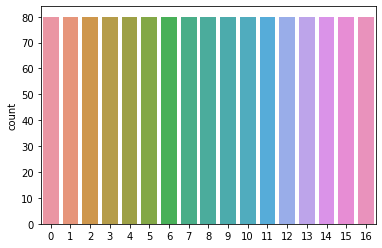

In [7]:
sns.countplot(x=y.argmax(axis=1))

Observation - Samples for all the class (0 -17) are distributed uniform  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


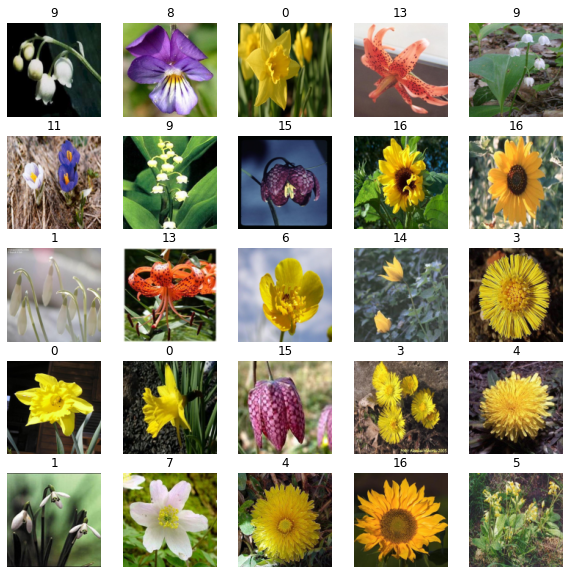

In [8]:
labels = y.argmax(axis=1)

fig=plt.figure(figsize=(10,10))
columns=5
rows=5
for i in range(1, columns*rows+1):
    img=x[i]
    fig.add_subplot(rows,columns,i)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# applying filters for the image

Kernal Size -  5


<Figure size 720x720 with 0 Axes>

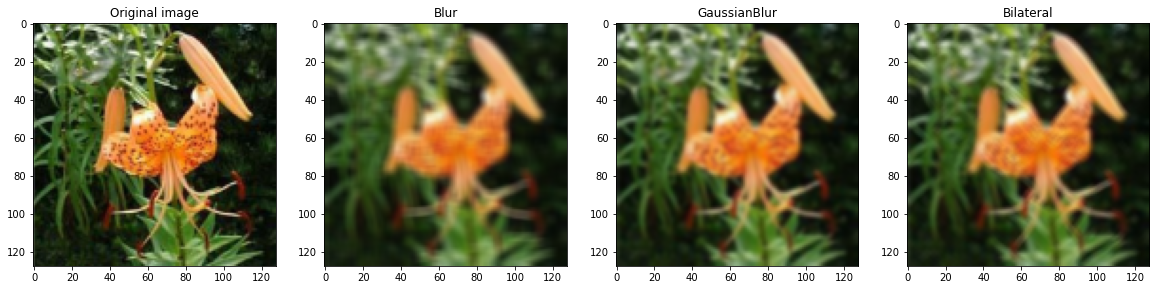

Kernal Size -  7


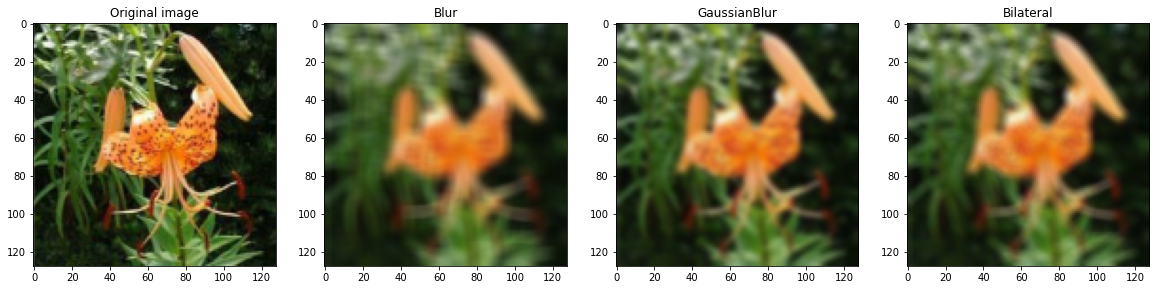

Kernal Size -  11


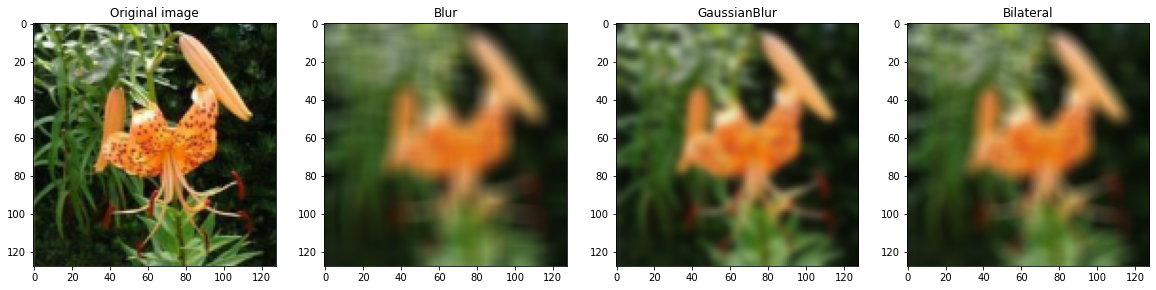

Kernal Size -  5


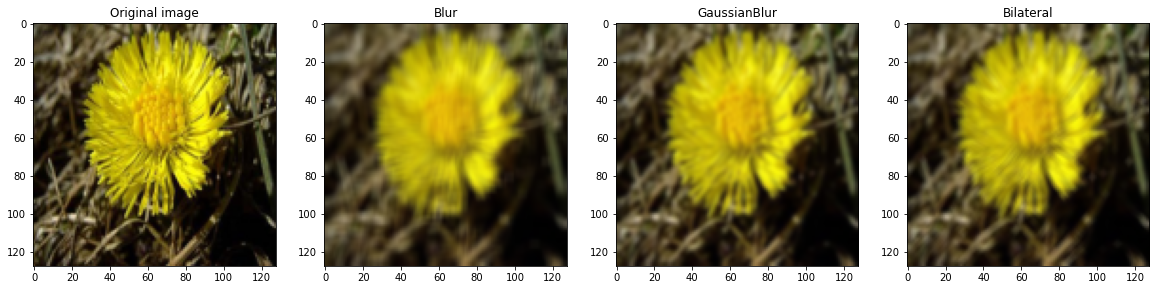

Kernal Size -  7


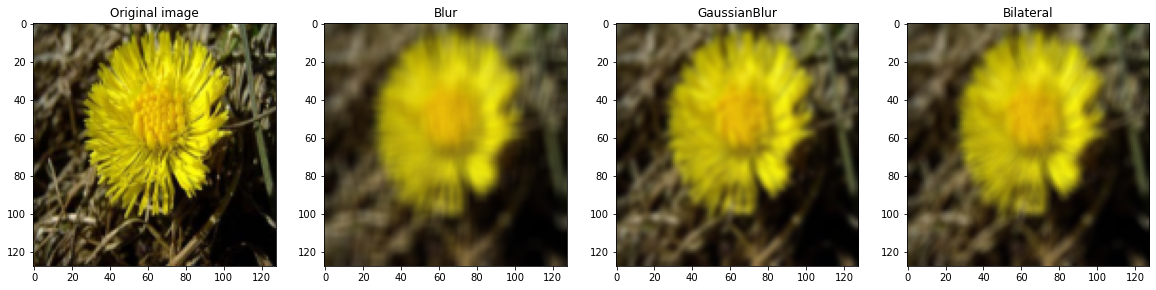

Kernal Size -  11


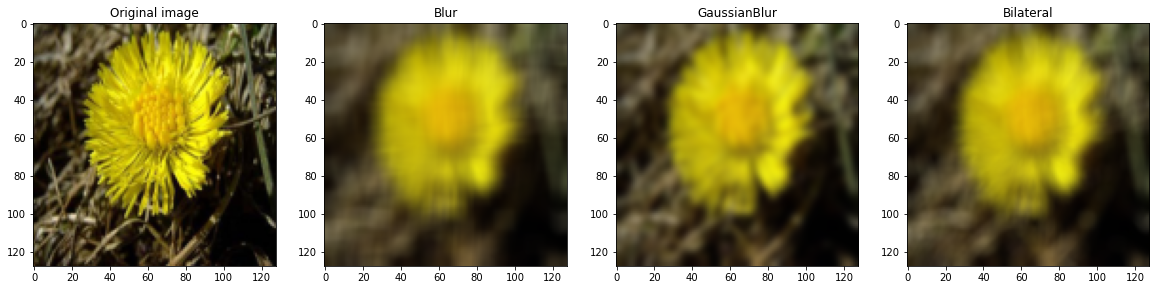

In [9]:
kernal_size_list = [5,7,11]
fig=plt.figure(figsize=(10,10))
columns=5
rows=5


def plot_img(images,title):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images),
                          figsize = (20, 20))
  index = 0
  for img in images:
        axs[index].imshow(img)
        axs[index].set_title(title[index])
        index = index +1
       
  plt.show()



for index in range(2):
    image_index = np.random.randint(0,1360)
    for kernal in kernal_size_list:
            print( "Kernal Size - ",kernal)
            img=x[image_index]
            a_img = cv2.blur(img,(kernal,kernal))
            g_img = cv2.GaussianBlur(img,(kernal,kernal),0)
            b_img = cv2.bilateralFilter(img,kernal,75,75)

            plot_img([img,a_img,g_img,b_img],["Original image","Blur","GaussianBlur","Bilateral"])



# Training Model

In [10]:
# data split
X_train, X_test, y_train, y_test = train_test_split(np.array(x), y, test_size=0.3, random_state=123)

## Normalize 
X_train =X_train /  255
X_test =X_test /  255

print("X_train min / max ", X_train.min(),X_train.max())
print("X_test min / max ", X_test.min(),X_test.max())

X_train_svc = X_train.reshape(X_train.shape[0],3*img_width*img_height)
print("X_train_svc data shape ", X_train_svc.shape)

X_test_svc= X_test.reshape(X_test.shape[0],3*img_width*img_height)
print("X_train_svc data shape ", X_test_svc.shape)

y_train_svc = y_train.argmax(axis=1)
print("y_train_svc data shape ", y_train_svc.shape)

y_test_svc = y_test.argmax(axis=1)
print("y_test_svc data shape ", y_test_svc.shape)


print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)



X_train min / max  0.0 0.00392157
X_test min / max  0.0 0.00392157
X_train_svc data shape  (952, 49152)
X_train_svc data shape  (408, 49152)
y_train_svc data shape  (952,)
y_test_svc data shape  (408,)
X_train data shape  (952, 128, 128, 3)
y_train data shape  (952, 17)
X_test data shape  (408, 128, 128, 3)
y_test data shape  (408, 17)


# Suport Vector classifier

In [11]:
%%time

pca = PCA(0.95)
estimator = SVC(kernel="rbf")
param_grid = {}
pipe = Pipeline(steps=[('pca', pca), ('estimator', estimator)])
gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1)

gridsearch.fit(X_train_svc,y_train_svc)
y_predict = gridsearch.predict(X_test_svc)

Wall time: 1min


train_score 0.92
test_score 0.47


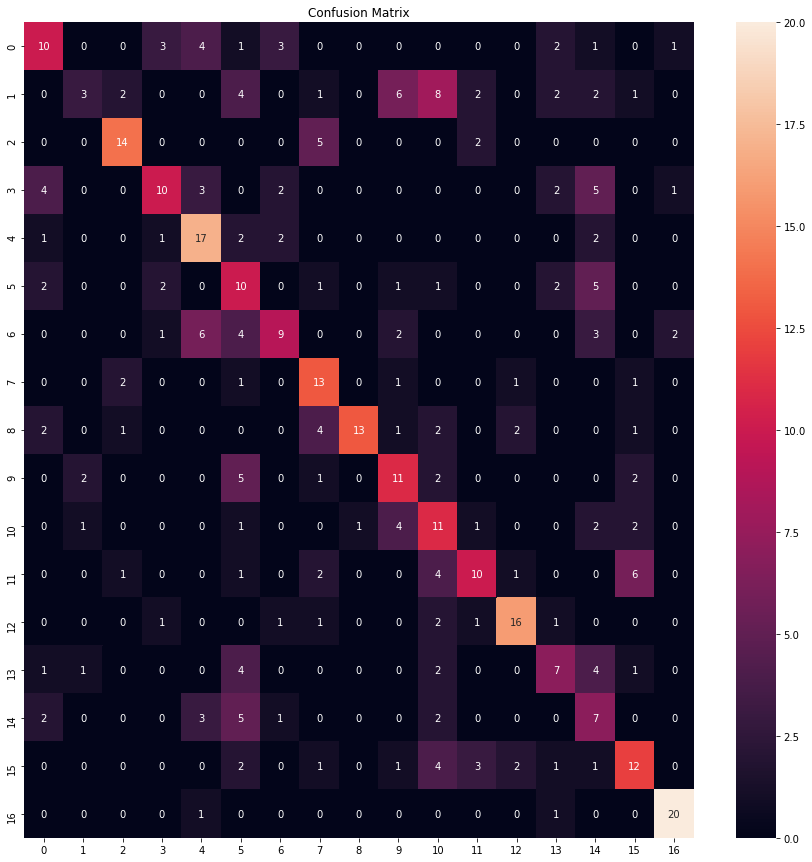

In [12]:
print("train_score" , round(gridsearch.score(X_train_svc,y_train_svc),2))
print("test_score", round(gridsearch.score(X_test_svc,y_test_svc),2))


fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(y_test_svc,y_predict)
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix'); 


# Nural Network

In [13]:
%%time

def nn_model_dropout():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(216, activation = "relu",kernel_initializer="he_normal"))   
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation = "relu",kernel_initializer="he_normal"))   
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(17, activation = "softmax"))
    return model


model_drop = nn_model_dropout()
optimizer = SGD(lr=0.001, momentum=0.9)

es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.05)
model_drop.compile(optimizer = optimizer, loss = 'categorical_crossentropy', 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)



fit_data = model_drop.fit(X_train, y_train, validation_data=(X_test,y_test),
                           batch_size = 32, epochs = 100, verbose = 1,callbacks=[es,learning_rate_reduction])

Train on 952 samples, validate on 408 samples
Epoch 1/100
952/952 [==============================] - 2s 2ms/sample - loss: 2.6398 - acc: 0.1849 - val_loss: 2.8317 - val_acc: 0.0833
Epoch 2/100
952/952 [==============================] - 2s 2ms/sample - loss: 1.9414 - acc: 0.3687 - val_loss: 2.8276 - val_acc: 0.0515
Epoch 3/100
952/952 [==============================] - 2s 2ms/sample - loss: 1.5249 - acc: 0.5431 - val_loss: 2.8209 - val_acc: 0.0711
Epoch 4/100
952/952 [==============================] - 2s 2ms/sample - loss: 1.3217 - acc: 0.6208 - val_loss: 2.8135 - val_acc: 0.0711
Epoch 5/100
952/952 [==============================] - 2s 2ms/sample - loss: 1.1208 - acc: 0.6964 - val_loss: 2.8037 - val_acc: 0.1495
Epoch 6/100
952/952 [==============================] - 2s 2ms/sample - loss: 0.9567 - acc: 0.7584 - val_loss: 2.7930 - val_acc: 0.1667
Epoch 7/100
952/952 [==============================] - 2s 2ms/sample - loss: 0.7839 - acc: 0.8067 - val_loss: 2.7749 - val_acc: 0.1373
Epoch 8/1

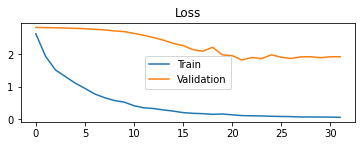

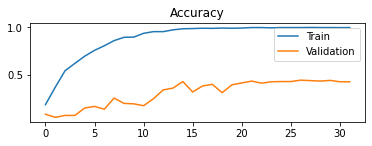

In [14]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(fit_data.history['loss'],label="Train")
plt.plot(fit_data.history['val_loss'],label="Validation")
plt.legend()
plt.show()

# plot loss during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(fit_data.history['acc'],label="Train")
plt.plot(fit_data.history['val_acc'],label="Validation")

plt.legend()
plt.show()

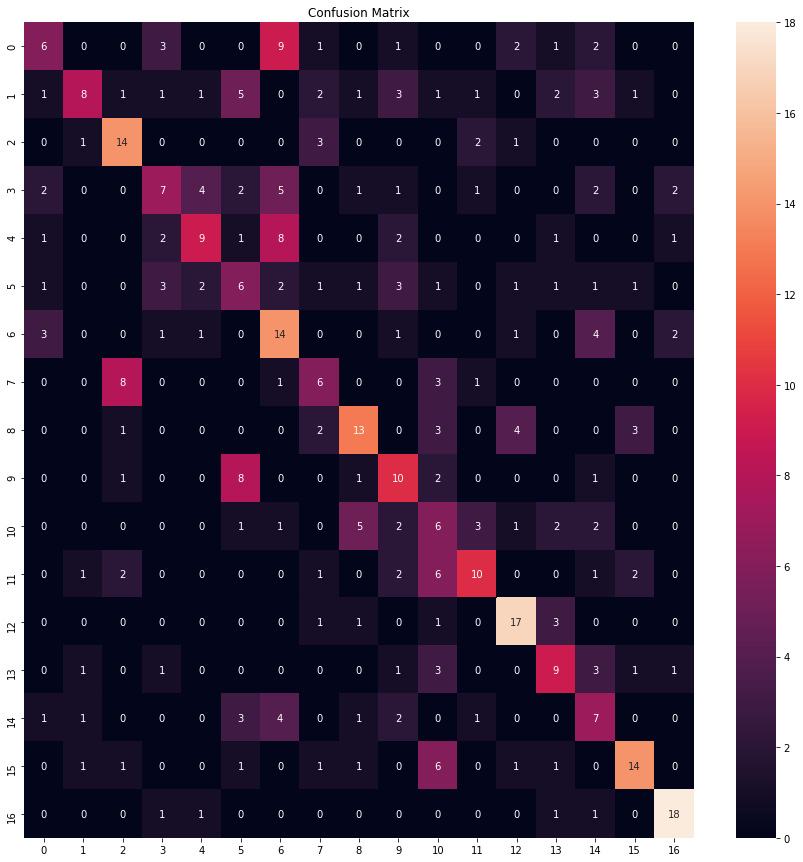

In [15]:
y_predict = model_drop.predict_classes(X_test)
fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(y_test_svc,y_predict)
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix'); 

# Conv Neural Network

In [16]:
subindex = [np.random.randint(0,X_train.shape[0]) for i in range(0,500)]
subindex_test = [np.random.randint(0,X_test.shape[0]) for i in range(0,50)]
X_train_subset=X_train[subindex]
y_train_subset=y_train[subindex]

X_test_subset = X_test[subindex_test]
y_test_subset = y_train[subindex_test]

In [17]:
datagen = ImageDataGenerator(
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        rotation_range = 15)
        

datagen.fit(X_train)

cnn1 = Sequential([
    Conv2D(96, kernel_size=(3, 3), activation='relu',padding='same',
           input_shape=(img_width, img_height, 3),kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3),strides=2),   
    
    Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same',kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3),strides=2),    
    Dropout(0.3),
    
    Flatten(),    
    Dense(64, activation='relu'),
    Dense(17, activation='softmax')
])

print(cnn1.summary())


optimizer = SGD(learning_rate=0.001)
cnn1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.01)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

cnn_fit_data = cnn1.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 200, validation_data = (X_test,y_test)
                                       ,steps_per_epoch = int(952/32)
                                       ,validation_steps = int(408/32)                                       
                              ,callbacks=[es,learning_rate_reduction])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 96)      2688      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 256)       221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 63, 63, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 256)      

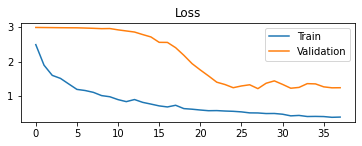

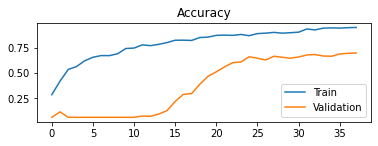

In [18]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(cnn_fit_data.history['loss'],label="Train")
plt.plot(cnn_fit_data.history['val_loss'],label="Validation")
plt.legend()
plt.show()

# plot loss during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(cnn_fit_data.history['acc'],label="Train")
plt.plot(cnn_fit_data.history['val_acc'],label="Validation")

plt.legend()
plt.show()

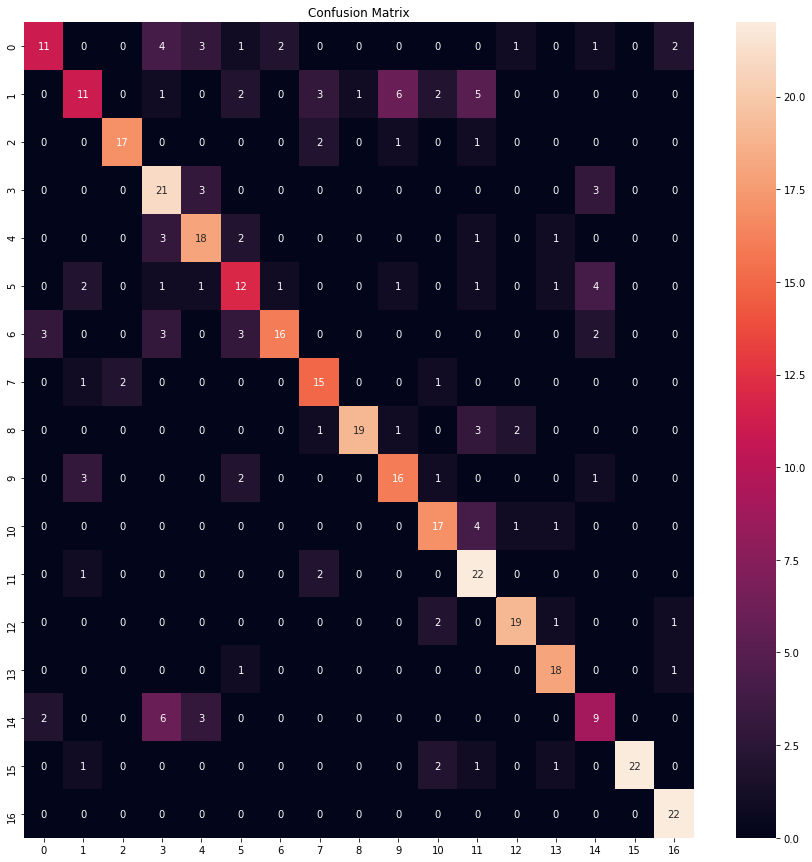

In [19]:
y_predict = cnn1.predict_classes(X_test)
fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(y_test_svc,y_predict)
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix'); 

# Save model for transfer learning

In [20]:
cnn1.save('./flower_prediction_model.h5')
cnn1.save_weights('./flower_prediction_weights.h5')

# Transferred learning 

- Transfer learning is about leveraging feature representations from a pre-trained model, so you don’t have to train a new model from scratch. 
- Conv layers of the model which is trained previously was used and Fully connected layer are replaced with different Fully connected NN

In [21]:
pretrained_model = load_model('./flower_prediction_model.h5')
pretrained_model.load_weights('./flower_prediction_weights.h5')
pretrained_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 96)      2688      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 256)       221440    
______________________________

In [22]:
for layer in pretrained_model.layers[:7]:
    print(layer)
    
pretrained_model = Sequential(pretrained_model.layers[:7])
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 96)      2688      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 256)       221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 63, 63, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 256)      

In [23]:
#The idea is to alter the training data with small transformations
datagen = ImageDataGenerator(
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        rotation_range = 15)
        

# Create the model
model = Sequential()
model.add(pretrained_model)

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(17, activation='softmax'))
    
  
    
optimizer = SGD(learning_rate=0.0001,momentum=0.9)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2,min_delta=0.01)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

fit_data = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 20, validation_data = (X_test,y_test)
                                       ,steps_per_epoch = int(952/32)
                                       ,validation_steps = int(408/32)                                       
                              ,callbacks=[es,learning_rate_reduction])

# fit_data = model.fit(X_train, y_train, validation_data=(X_test,y_test),
#                            batch_size = 32, epochs = 20, verbose = 1,callbacks=[es,learning_rate_reduction])


Epoch 1/20
29/29 [==============================] - 280s 9s/step - batch: 14.0000 - size: 31.7241 - loss: 2.5752 - acc: 0.2543 - val_loss: 1.7427 - val_acc: 0.4534
Epoch 2/20
15/29 [==============>...............] - ETA: 2:02 - batch: 7.0000 - size: 31.4667 - loss: 1.6809 - acc: 0.4852

KeyboardInterrupt: 

In [ ]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(fit_data.history['loss'],label="Train")
plt.plot(fit_data.history['val_loss'],label="Validation")
plt.legend()
plt.show()

# plot loss during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(fit_data.history['acc'],label="Train")
plt.plot(fit_data.history['val_acc'],label="Validation")

plt.legend()
plt.show()

In [ ]:
y_predict = model.predict_classes(X_test)
fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(y_test_svc,y_predict)
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix'); 

In [ ]:
testing model  with Test Image 

test_image = cv2.imread('./17flowers/Prediction - Flower.jpg')
print(test_image.shape)
test_image = cv2.resize(test_image,(img_width,img_height), interpolation = cv2.INTER_AREA)
print(test_image.shape)
plt.imshow(test_image)

test_image_expanded = np.expand_dims(test_image, axis = 0)
print(test_image.shape)

test_image_expanded =test_image_expanded*1/255.0

result = model.predict_classes(test_image_expanded)
result

Observation